## Load the dataset

In [ ]:
import urllib.request as req
from urllib.parse import urlparse
import os
import progressbar
import zipfile
import gzip
import shutil
import json
import pandas as pd
import re
import string
import imblearn

pbar = None


def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)
        pbar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

def wget(url):
    a = urlparse(url)
    filename = os.path.basename(a.path)
    if not os.path.isfile(filename):
        req.urlretrieve(url, filename, show_progress)
        print(f'downloaded to {filename}')
    else:
        print(f'file {filename} has already been downloaded')
    return filename

def unzip(filename, directory_to_extract_to=os.getcwd()):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)
        print(f'extraction done {zip_ref.namelist()}')

def gunzip(gzfile, fout):
    with gzip.open(gzfile, 'rb') as f_in:
        with open(fout, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f'{gzfile} extracted to {fout}')


# map punctuation to space
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 

def text_preprocessing(df):
    """
    Preprocess the text for better understanding
    
    """
    # trim the whitespace at the edges of the string
    df['reviewText'] = df['reviewText'].str.strip()

    # lowercase the text in the string
    df['reviewText'] = df['reviewText'].str.lower()

    # replace new line with a .

    df['reviewText'] = df['reviewText'].replace('\n', ' . ')

    return df


filename = wget("https://nlp.stanford.edu/data/glove.6B.zip")
unzip(filename)
Video_Games_5 = wget('http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Video_Games_5.json.gz')
df = pd.read_json("./Video_Games_5.json.gz", lines=True, compression='gzip')
df = df[['reviewText', 'overall']]
df = text_preprocessing(df)
df = df.dropna()
df = df.drop_duplicates()
print(df.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
100% (862182613 of 862182613) |##########| Elapsed Time: 0:02:41 Time:  0:02:41


downloaded to glove.6B.zip
extraction done ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']


100% (154050105 of 154050105) |##########| Elapsed Time: 0:00:07 Time:  0:00:07


downloaded to Video_Games_5.json.gz
(400985, 2)


In [ ]:
df.head()

,reviewText,overall
0,"this game is a bit hard to get the hang of, bu...",5.0
1,i played it a while but it was alright. the st...,4.0
2,ok game.,3.0
3,"found the game a bit too complicated, not what...",2.0
4,"great game, i love it and have played it since...",5.0


## Counts of the labels

number of samples in the dataset:  400985
unique labels in the dataset:  [5.0, 4.0, 3.0, 2.0, 1.0]
5.0    224526
4.0     81930
3.0     44206
1.0     27952
2.0     22371
Name: overall, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


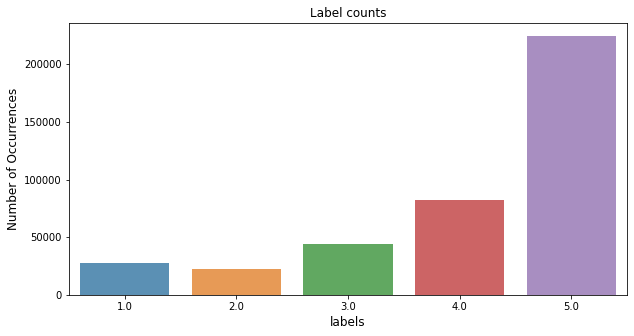

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print('number of samples in the dataset: ', len(df))
print('unique labels in the dataset: ', list(df.overall.unique()))

label_counts  = df.overall.value_counts()
print(label_counts)
plt.figure(figsize=(10,5))
sns.barplot(label_counts.index, label_counts.values, alpha=0.8)
plt.title('Label counts')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('labels', fontsize=12)
plt.show()

In [ ]:
df['text'] = df['reviewText']

## Size of the messages

In [ ]:
max(df['text'].str.len())

32721

In [ ]:
MAXLEN = 3000
len(df[df['text'].str.len()<MAXLEN])/len(df)

0.9458184221354914

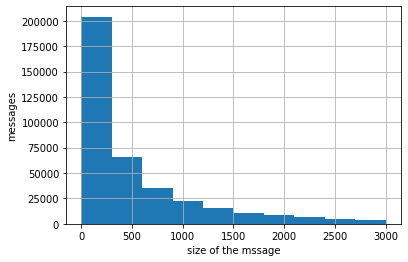

In [ ]:
import matplotlib.pyplot as plt

ax = df[df['text'].str.len()<MAXLEN]['text'].str.len().hist()
ax.set_xlabel("size of the mssage")
ax.set_ylabel("messages")
plt.show()

## Words in the message

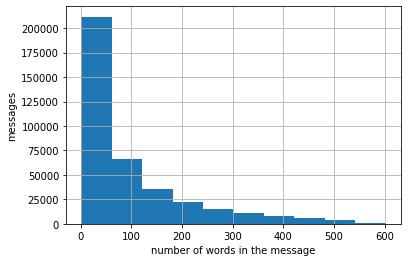

In [ ]:
ax = df[df['text'].str.len()<MAXLEN]['text'].str.split()\
    .map(lambda x: len(x))\
    .hist()
ax.set_xlabel("number of words in the message")
ax.set_ylabel("messages")
plt.show()

## Mean number of words in the message

Generally the length of the text hovers around 5 words

In [ ]:
df['text'].str.split() \
   .apply(lambda x : [len(i) for i in x]) \
   .map(lambda x: np.mean(x))

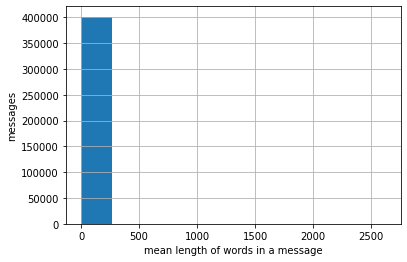

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ax = df['text'].str.split() \
   .apply(lambda x : [len(i) for i in x]) \
   .map(lambda x: np.mean(x)).hist()
ax.set_xlabel("mean length of words in a message")
ax.set_ylabel("messages")
plt.show()

## Common words used in the reviews

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

['this', 'game']


<BarContainer object of 10 artists>

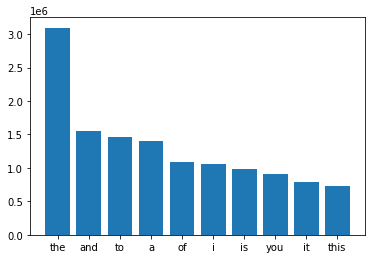

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline


stop = stopwords.words('english')

corpus = []
texts = df['text'].str.split()
texts = texts.values.tolist()
corpus = [word for i in texts for word in i]
print(corpus[:2])

counter = Counter(corpus)
most = counter.most_common()

top = sorted(most[:10], key=lambda x:x[1], reverse=True)[:10] 
x, y = zip(*top)
plt.bar(x, y)

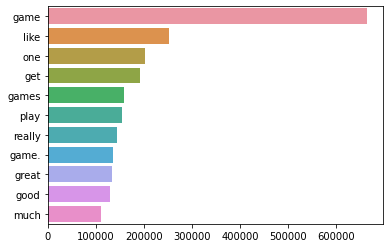

In [ ]:
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
stop = stopwords.words('english')

counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:60]:
    if ((word not in stop) and (word!='.')):
        x.append(word)
        y.append(count)
        
# fig, ax = plt.subplots(figsize=(8, 8))
# sns.barplot(ax=ax, x=y, y=x)
sns.barplot(x=y, y=x)

## Common phrases

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stop = stopwords.words('english')

def remove_stop(text):
    text = text.split()
    text = [t for t in text if t not in stop]
    return " ".join(text)

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

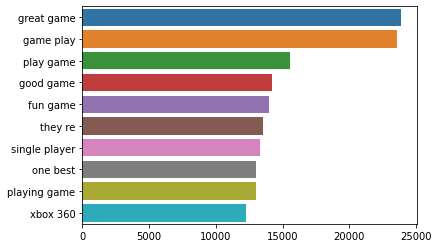

In [ ]:
df['text'] = df['text'].apply(lambda text: remove_stop(text))
top_n_bigrams = get_top_ngram(df['text'], 2)[:10]
x, y = map(list, zip(*top_n_bigrams))
sns.barplot(x=y, y=x)

In [ ]:
df['text'] = df['text'].apply(lambda text: remove_stop(text))
top_tri_grams = get_top_ngram(df['text'], n=3)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y, y=x)

In [ ]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

In [ ]:
df['text1'] = df['text'].apply(lambda x: [item for item in x.split() if item not in stop])

In [ ]:
df['text'].\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

## Topic Distribution using LDA

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

def preprocess_text(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['text']:
        words = [w for w in word_tokenize(news) if (w not in stop)]
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

corpus = preprocess_text(df)

In [ ]:
import gensim

dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

lda_model = gensim.models.LdaMulticore(
    bow_corpus, num_topics = 4, id2word = dic, passes = 10, workers = 2)
lda_model.show_topics()

In [ ]:
!pip install pyLDAvis

In [ ]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


def get_lda_objects(text):
    nltk.download('stopwords')    
    stop = set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem = PorterStemmer()
        lem = WordNetLemmatizer()
        for news in text:
            words = [w for w in word_tokenize(news) if (w not in stop)]

            words = [lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda_model, bow_corpus, dic)
    return vis

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(df['text'])

In [ ]:
lda_model.show_topics()

In [ ]:
# plot_lda_vis(lda_model, bow_corpus, dic)

## Word Cloud

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop = set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem = PorterStemmer()
        lem = WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()


plot_wordcloud(df['text'])

### Word cloud for label 1

In [ ]:
plot_wordcloud(df[df.overall==1]['text'])

### Word cloud for label 5

In [ ]:
plot_wordcloud(df[df.overall==5]['text'])

## Polarity

In [ ]:
from textblob import TextBlob

def polarity(text):
    return TextBlob(text).sentiment.polarity
    
df['polarity_score'] = df['text'].apply(lambda x : polarity(x))

df['polarity_score'].hist()

In [ ]:
import matplotlib.pyplot as plt

def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
df['polarity'] = df['polarity_score'].map(lambda x: sentiment(x))
plt.bar(df.polarity.value_counts().index, df.polarity.value_counts())

In [ ]:
df[df['polarity']=='pos']['text'].head()

In [ ]:
df[df['polarity']=='neg']['text'].head()

## Entities in the text

In [ ]:
%%capture
!python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
from spacy import displacy

doc = nlp(list(df.sample()['reviewText'].to_dict().values())[0])
displacy.render(doc, style='ent')

from spacy import displacy

displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

In [ ]:
%%capture
from collections import Counter
from tqdm.auto import tqdm
tqdm.pandas()

def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = df['text'].apply(lambda x : ner(x))

ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

In [ ]:
from spacy import displacy

doc = nlp(list(df.sample()['text'].to_dict().values())[0])
displacy.render(doc, style='ent')

In [ ]:
import seaborn as sns

print(count)
x, y = map(list, zip(*count))
sns.barplot(x=y, y=x)